In [1]:
import pandas as pd
import numpy as np

import eda
from eda import Documents

import sentiment
from sentiment import Sentiment

In [2]:
df_imdb = pd.read_csv('data/IMDB Dataset - Small.csv')
print("Columns in Data: '{0}', '{1}'.".format(df_imdb.columns[0], df_imdb.columns[1]))
print("Data has {0} rows & {1} columns".format(df_imdb.shape[0], df_imdb.shape[1]))

Columns in Data: 'review', 'sentiment'.
Data has 1000 rows & 2 columns


In [3]:
doc_obj = Documents(data_frame=df_imdb, text_column='review')
df_imdb_clean = doc_obj.prep_docs(return_df=True)
# doc_obj.explore()
# doc_obj.create_wordcloud()

In [4]:
sent_obj = Sentiment(documents_object=doc_obj, method='lexical', lexicon='loughran')
sent_obj.plot_sentiment()

In [5]:
sent_obj.plot_word_sentiment()

NameError: name 'CountVectorizer' is not defined

In [11]:
from ploty_template import custom_template, plot_title
import plotly.graph_objects as go
import plotly.express as px

In [28]:
fig1 = go.Figure(data=[go.Bar(x=['A','B','C'], y=[1,2,3])])
fig1.update_layout(template="plotly_white", title=plot_title("Frequent Words"))
fig1.show()

In [13]:
import os, pickle
import numpy as np
import pandas as pd
from PIL import Image
# import swifter
from bs4 import BeautifulSoup
from itertools import chain
import re, string, unicodedata
# import contractions
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

In [5]:
# Spacy
import spacy
nlp = spacy.load('en_core_web_md')

In [6]:
# Plots
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
# %matplotlib inline

In [4]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.parsing.preprocessing import remove_stopwords
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger

G:\Users\soura\miniconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [35]:
# Plots
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# %matplotlib inline

In [8]:
global DATA_PATH, RESULTS_PATH, MODEL_PATH, UTIL_PATH

UTIL_PATH = "utils"
# DATA_PATH = "../data"
# RESULTS_PATH = "../results"
# MODEL_PATH = "../model"

In [ ]:
################## Stopwords list ##################
stop1 = [re.sub(r"(\|(.)+)|(\n)", "", x.lower()) for x in open(UTIL_PATH+"/stopwords/"+"StopWords_Generic.txt", "r")]
stop2 = [re.sub(r"(\|(.)+)|(\n)", "", x.lower()) for x in open(UTIL_PATH+"/stopwords/"+"StopWords_GenericLong.txt", "r")]
stop3 = [re.sub(r"(\|(.)+)|(\n)", "", x.lower()) for x in open(UTIL_PATH+"/stopwords/"+"StopWords_DatesandNumbers.txt", "r")]

custom_stp = ['say','million','year','quarter', 'month', 'thank','company','see', 'hi', 'hello', 'how',
                 'think','get','look','okay','well','question', 'billion','management','be', 'sgd', 'usd', 'i', 'I', 'want', 'go', 
                 'thanks','morning','please','afternoon','mean','sort','guess','lot', 'right', 'much', 'would', 'could', 'bit', 
                 'like', 'give','take','expect','wonder','try','might','maybe','may','mr', 'sir', 'ahead', 'lady', 'gentleman']

In [ ]:
stop_words = set(stopwords.words("english") + STOPWORDS + stop1 + stop2 + stop3 + custom_stp)

In [72]:
class Documents:   
    def __init__(self, stop_words=None, data_frame=None, text_column=None):
        self.stop_words = stop_words
        self.clean_status = False

        if (isinstance(data_frame, pd.DataFrame) & isinstance(text_column, str)):
            self.raw_df = data_frame
            self.processed_df = self.raw_df
        else:
            raise TypeError("data_frame should be a dataframe and the text_column should be string")
        
        if str(text_column) in self.raw_df.columns:
            self.text_column = text_column 
        else:
            raise ValueError("Cannot find " + str(text_column) + " in the dataframe.")
        
   

    ################## Text Cleaning ##################
        
    def __flatten(self, listOfLists):
        "Flatten one level of nesting"
        return list(chain.from_iterable(listOfLists))
    
    # Lemmatize with POS Tag
    # def __get_wordnet_pos(self, word):
    #     """Map POS tag to first character lemmatize() accepts"""
    #     tag = nltk.pos_tag([word])[0][1][0].upper()
    #     tag_dict = {"J": wordnet.ADJ,
    #                 "N": wordnet.NOUN,
    #                 "V": wordnet.VERB,
    #                 "R": wordnet.ADV}
    #     return tag_dict.get(tag, wordnet.NOUN)

    def __strip_html_tags(self, text):
        soup = BeautifulSoup(text, "html.parser")
        [s.extract() for s in soup(['iframe', 'script'])]
        stripped_text = soup.get_text()
        stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
        return stripped_text

    def __remove_accented_chars(self, text):
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return text

    # def __expand_contractions(self, text):
    #     return contractions.fix(text)

    def __remove_special_characters(self, text, remove_digits=False):
        pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
        text = re.sub(pattern, '', text)
        return text

    def __clean_text(self, document):        
        # converting to text
        document =  str(document)

        # strip HTML
        document = self.__strip_html_tags(document)

        # lower case
        document = document.lower()

        # remove extra newlines (often might be present in really noisy text)
        document = document.translate(document.maketrans("\n\t\r", "   "))

        # remove accented characters
        document = self.__remove_accented_chars(document)
        document = re.sub(r"x+", "", document)
        document = re.sub(r"(<br/>)", "", document)
        document = re.sub(r"(<a).*(>).*(</a>)", "", document)
        document = re.sub(r"(&amp)", "", document)
        document = re.sub(r"(&gt)", "", document)
        document = re.sub(r"(&lt)", "", document)
        document = re.sub(r"(\xa0)", " ", document)

        # remove special characters and\or digits    
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        document = special_char_pattern.sub(" \\1 ", document)
        document = self.__remove_special_characters(document, remove_digits=True)  

        # remove extra whitespace
        document = re.sub(' +', ' ', document)
        document = document.strip()
        
        # expand contractions    
        # document = self.__expand_contractions(document)

        # Split the documents into tokens.
        tokenizer = RegexpTokenizer(r'\w+')
        document = document.lower()  # Convert to lowercase.
        document = tokenizer.tokenize(document)  # Split into words.

        # Remove numbers, but not words that contain numbers.
        # Remove words that are only one character.
        # Remove stopwords
        document = [token for token in document if not token.isnumeric()]
        document = [token for token in document if len(document) > 1]   
        document = [word for word in document if not word in self.stop_words]
        document = " ".join(document)
        
        # lemmatize
        document = [token.lemma_ for token in nlp(document) if not token.is_stop]
        document = [word for word in document if not word in self.stop_words]
        document = " ".join(document)

        return document

    
    def prep_docs(self, return_df=True):
        cleaned_text = str(self.text_column) + "_clean"
        self.processed_df[cleaned_text] = self.processed_df[self.text_column].apply(lambda x: self.__clean_text(x))
        self.clean_status = True
        if return_df:
            return self.processed_df


    def __get_ngrams(self, corpus, nwords=20, min_count=1, ngram=1, most_frequent_first=True):
        vec = CountVectorizer(ngram_range(ngram,ngram)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items() if idx >= min_count]
        if most_frequent_first:
            words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        else:
            words_freq =sorted(words_freq, key = lambda x: x[1], reverse=False)
        temp_df = pd.DataFrame(words_freq[:nwords] , columns = ['Phrase' , 'Count'])     
        return temp_df   


    def __plot_cloud(self, wordcloud):
        # Set figure size
        plt.figure(figsize=(40, 30))
        # Display image
        plt.imshow(wordcloud) 
        # No axis details
        plt.axis("off")


    ##################### Exploratory Data Analysis #####################

    def explore(self, ngram_range=(1,1), nwords=20, min_count=1):
        cleaned_text = str(self.text_column) + "_clean"
        if not self.clean_status:
            self.prep_docs(return_df=False)

        if (isinstance(ngram_range, tuple)) & (ngram_range[0] > 0) & (ngram_range[1] >= ngram_range[0]):
            self.ngram_range = ngram_range 
        else:
            raise TypeError("ngram_range has to be a tuple with first_term / lower-limit less-than or equal-to the second term / upper-limit")

        for ng in range(self.ngram_range[0], self.ngram_range[1]+1):
            if ng==1:
                temp_df1 = self.__get_ngrams(self.processed_df[cleaned_text], nwords=nwords, min_count=min_count, ngram=ng, most_frequent_first=True)
                temp_df1.groupby('Phrase').sum()['Count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='Frequent Words')
                temp_df2 = self.__get_ngrams(self.processed_df[cleaned_text], nwords=nwords, min_count=min_count, ngram=ng, most_frequent_first=False)
                temp_df2.groupby('Phrase').sum()['Count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='Rare Words')
            else:
                temp_df1 = self.__get_ngrams(self.processed_df[text_column], nwords=nwords, min_count=min_count, ngram=ng, most_frequent_first=True)
                temp_df1.groupby('Phrase').sum()['Count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='Frequent Phrases')
                temp_df2 = self.__get_ngrams(self.processed_df[text_column], nwords=nwords, min_count=min_count, ngram=ng, most_frequent_first=False)
                temp_df2.groupby('Phrase').sum()['Count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='Rare Phrases')
        
        # Import image to np.array & Generate word cloud
        mask = np.array(Image.open(UTIL_PATH + "/wordcloud_mask/" + "comment.png"))
        text = " ".join(self.processed_df[cleaned_text].tolist())
        wordcloud = WordCloud(width=3000, height=2000, random_state=1, background_color='white', colormap='Set2', collocations=False, 
        stopwords=self.stop_words, mask=mask).generate(text)
        self.__plot_cloud(wordcloud)
    

In [ ]:
# NLTK
import nltk
from nltk.corpus import stopwords
from nltk import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer 
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

In [54]:
class Sentiment:
    def __init__(self, documents_object=None, method=None, lexicon=None):
        if isinstance(documents, Documents):
            self.doc_obj = documents_object
            self.raw_df = documents_object.raw_df
            if documents_object.clean_status:
                self.processed_df = documents_object.processed_df
                self.text_column = documents_object.text_column
            else:
                raise ValueError("Please run the prep_docs method on the Documents object first.")
            if method in ['lexical', 'textblob', 'vader']:
                self.sent_method = method
                if method == 'lexical':
                    if lexicon in ['loughran', 'nrc']:
                        self.sent_lexicon = lexicon
                    else:
                        raise ValueError("Please choose lexicon as either of loughran / nrc")
            else:
                raise ValueError("Please choose method as either of lexical / textblob / vader")
        else:
            raise TypeError("Only an object of Documents Class can be passed.")


    def __load_loughran(self):
        #Load master dictionary
        master = pd.read_csv(UTIL_PATH + "/lexicons/loughran/" + "LoughranMcDonald_MasterDictionary_2018.csv")
        pos_words = master[master["Positive"]>0].Word.str.lower().tolist()
        neg_words = master[master["Negative"]>0].Word.str.lower().tolist()
        unc_words = master[master["Uncertainty"]>0].Word.str.lower().tolist()
        lit_words = master[master["Litigious"]>0].Word.str.lower().tolist()
        con_words = master[master["Constraining"]>0].Word.str.lower().tolist()
        sup_words = master[master["Superfluous"]>0].Word.str.lower().tolist()
        comb_list = [pos_words, neg_words, unc_words, lit_words, con_words, sup_words]
        return comb_list

    
    def __sent_loughran(self, x, loughran_list):
        cleaned_text = str(self.text_column) + "_clean"
        pos_cnt = neg_cnt = unc_cnt = lit_cnt = con_cnt = sup_cnt = 0
        for word in x[cleaned_text]:
            if word in loughran_list[0]:
                pos_cnt += 1
            if word in loughran_list[1]:
                neg_cnt += 1
            if word in loughran_list[2]:
                unc_cnt += 1
            if word in loughran_list[3]:
                lit_cnt += 1
            if word in loughran_list[4]:
                con_cnt += 1
            if word in loughran_list[5]:
                sup_cnt += 1
        x['pos_shr'] = 100*pos_cnt / (pos_cnt + neg_cnt + unc_cnt + lit_cnt + con_cnt + sup_cnt)
        x['neg_shr'] = 100*neg_cnt / (pos_cnt + neg_cnt + unc_cnt + lit_cnt + con_cnt + sup_cnt)
        x['unc_shr'] = 100*unc_cnt / (pos_cnt + neg_cnt + unc_cnt + lit_cnt + con_cnt + sup_cnt)
        x['lit_shr'] = 100*lit_cnt / (pos_cnt + neg_cnt + unc_cnt + lit_cnt + con_cnt + sup_cnt)
        x['con_shr'] = 100*con_cnt / (pos_cnt + neg_cnt + unc_cnt + lit_cnt + con_cnt + sup_cnt)
        x['sup_shr'] = 100*sup_cnt / (pos_cnt + neg_cnt + unc_cnt + lit_cnt + con_cnt + sup_cnt)
        x['sent_scr'] = (pos_cnt - neg_cnt) / (pos_cnt + neg_cnt)
        return x

    
    def __generate_sentiment(self):
        temp_df = self.processed_df
        if self.sent_method == 'lexical':
            if self.sent_lexicon == 'loughran':
                loughran_list = self.__load_loughran()
                temp_df = temp_df.apply(self.__sent_loughran(loughran_list=loughran_list), axis=1)
        return temp_df


    def plot_sentiment(self, X_variable=None, return_df=True):
        temp_df = self.__generate_sentiment()
        if self.sent_method == 'lexical':
            if self.sent_lexicon == 'loughran':
                # plot now
                if X_catX_variableegory is None:
                    avg_sent = round(temp_df['sent_scr'].mean(),2)
                    avg_pos = round(temp_df['pos_shr'].mean(),1)
                    avg_neg = round(temp_df['neg_shr'].mean(),1)
                    avg_unc = round(temp_df['unc_shr'].mean(),1)
                    avg_lit = round(temp_df['lit_shr'].mean(),1)
                    avg_con = round(temp_df['con_shr'].mean(),1)
                    avg_sup = round(temp_df['sup_shr'].mean(),1)
                    labels = ['Positive', 'Negative', 'Uncertainty', 'Litigious', 'Constraining', 'Superfluous']
                    values = [avg_pos, avg_neg, avg_unc, avg_lit, avg_con, avg_sup]
                    fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4, hoverinfo="label+percent+name")])
                    fig.update_layout(title_text="Overall Sentiment Score: " + str(avg_sent))
                    fig.show()
                else:
                    tdf = temp_df[[X_variable,'sent_scr','pos_shr','neg_shr','unc_shr','lit_shr','con_shr','sup_shr']].groupby([X_variable]).mean()
                    tdf.sort_index(inplace=True).reset_index(inplace=True)
                    fig = make_subplots(rows=3, cols=1, specs = [[{}], [{"rowspan": 2}], [None]], shared_xaxes=True, vertical_spacing=0.00)
                    fig.add_trace(go.Scatter(x=tdf[X_variable], y=tdf['sent_scr'], mode='lines+markers', line_shape='spline', name='Sentiment Score'), row=1, col=1)
                    fig.add_trace(go.bar(x=tdf[X_variable], y=tdf['pos_shr'].round(1), name='Positive'), row=2,col=1)
                    fig.add_trace(go.bar(x=tdf[X_variable], y=tdf['neg_shr'].round(1), name='Negative'), row=2,col=1)
                    fig.add_trace(go.bar(x=tdf[X_variable], y=tdf['unc_shr'].round(1), name='Uncertainty'), row=2,col=1)
                    fig.add_trace(go.bar(x=tdf[X_variable], y=tdf['lit_shr'].round(1), name='Litigious'), row=2,col=1)
                    fig.add_trace(go.bar(x=tdf[X_variable], y=tdf['con_shr'].round(1), name='Constraining'), row=2,col=1)
                    fig.add_trace(go.bar(x=tdf[X_variable], y=tdf['sup_shr'].round(1), name='Superfluous'), row=2,col=1)
                    fig.update_layout(barmode='stack', plot_bgcolor="white", yaxis_visible=False, yaxis_showticklabels=False,
                    yaxis2_visible=False, yaxis2_showticklabels=False)
                    fig.show()
        if return_df:
            return temp_df 


In [ ]:
from gensim.summarization import summarize, keywords

In [ ]:
class Summary:
    def __init__(self, documents_object=None, method=None, summary_ratio=None, keyword_ratio=None):
        if isinstance(documents, Documents):
            self.doc_obj = documents_object
            self.raw_df = documents_object.raw_df
            if documents_object.clean_status:
                self.processed_df = documents_object.processed_df
                self.text_column = documents_object.text_column
            else:
                raise ValueError("Please run the prep_docs method on the Documents object first.")
            if method in ['summary', 'all']:
                if (summary_ratio > 0 & summary_ratio < 1.0):
                    self.summary_ratio = summary_ratio
                else:
                    raise ValueError("Summary-Ratio should be between (0, 1) non-inclusive rage")
            else:
                raise ValueError("Please choose method as either of summary / keyword / all")
            if method in ['keyword', 'all']:
                if (keyword_ratio > 0 & keyword_ratio < 1.0):
                    self.keyword_ratio = keyword_ratio
                else:
                    raise ValueError("KeyWord-Ratio should be between (0, 1) non-inclusive rage")
            else:
                raise ValueError("Please choose method as either of summary / keyword / all")
        else:
            raise TypeError("Only an object of Documents Class can be passed.")
    
    def __get_summary():


In [ ]:
 ################## Topic Modeling Formatted output ##################

    def format_topics_sentences(self, ldamodel=None, corpus=None, texts=None):
        # Init output
        sent_topics_df = pd.DataFrame()

        # Get main topic in each document
        for i, row_list in enumerate(ldamodel[corpus]):
            row = row_list[0] if ldamodel.per_word_topics else row_list            
            # print(row)
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            # Get the Dominant topic, Perc Contribution and Keywords for each document
            for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0:  # => dominant topic
                    wp = ldamodel.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                else:
                    break
        sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

        # Add original text to the end of the output
        contents = pd.Series(texts)
        sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
        return sent_topics_df

In [ ]:

common_words = get_top_n_words(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

In [ ]:


vec = CountVectorizer().fit(corpus)
bag_of_words = vec.transform(corpus)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [14]:
corpus = [
...     'This is the first document.',
...     'This document is the second document.',
...     'And this is the third one.',
...     'Is this the first document?',
... ]

In [28]:
vec = CountVectorizer().fit(corpus)
bag_of_words = vec.transform(corpus)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

In [20]:
vec.vocabulary_.items()

dict_items([('this', 8), ('is', 3), ('the', 6), ('first', 2), ('document', 1), ('second', 5), ('and', 0), ('third', 7), ('one', 4)])

In [36]:
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=False)

In [51]:
for i in range(1, 3):
    print(i)

1
2


In [52]:
xx  = (1,2)
type(df2) == pandas.core.frame.DataFrame

pandas.core.frame.DataFrame

In [29]:
df2 = pd.DataFrame(words_freq, columns = ['ReviewText' , 'count'])

In [30]:
for x in df2['ReviewText']:
    print(x)

this
is
the
first
document
second
and
third
one


In [65]:
'pp' not in df2.columns


True

In [70]:
text = " ".join(corpus)
wordcloud = WordCloud(width=3000, height=2000, random_state=1, background_color='white', colormap='Set2', collocations=False, 
stopwords=STOPWORDS).generate(text)

(-0.5, 2999.5, 1999.5, -0.5)

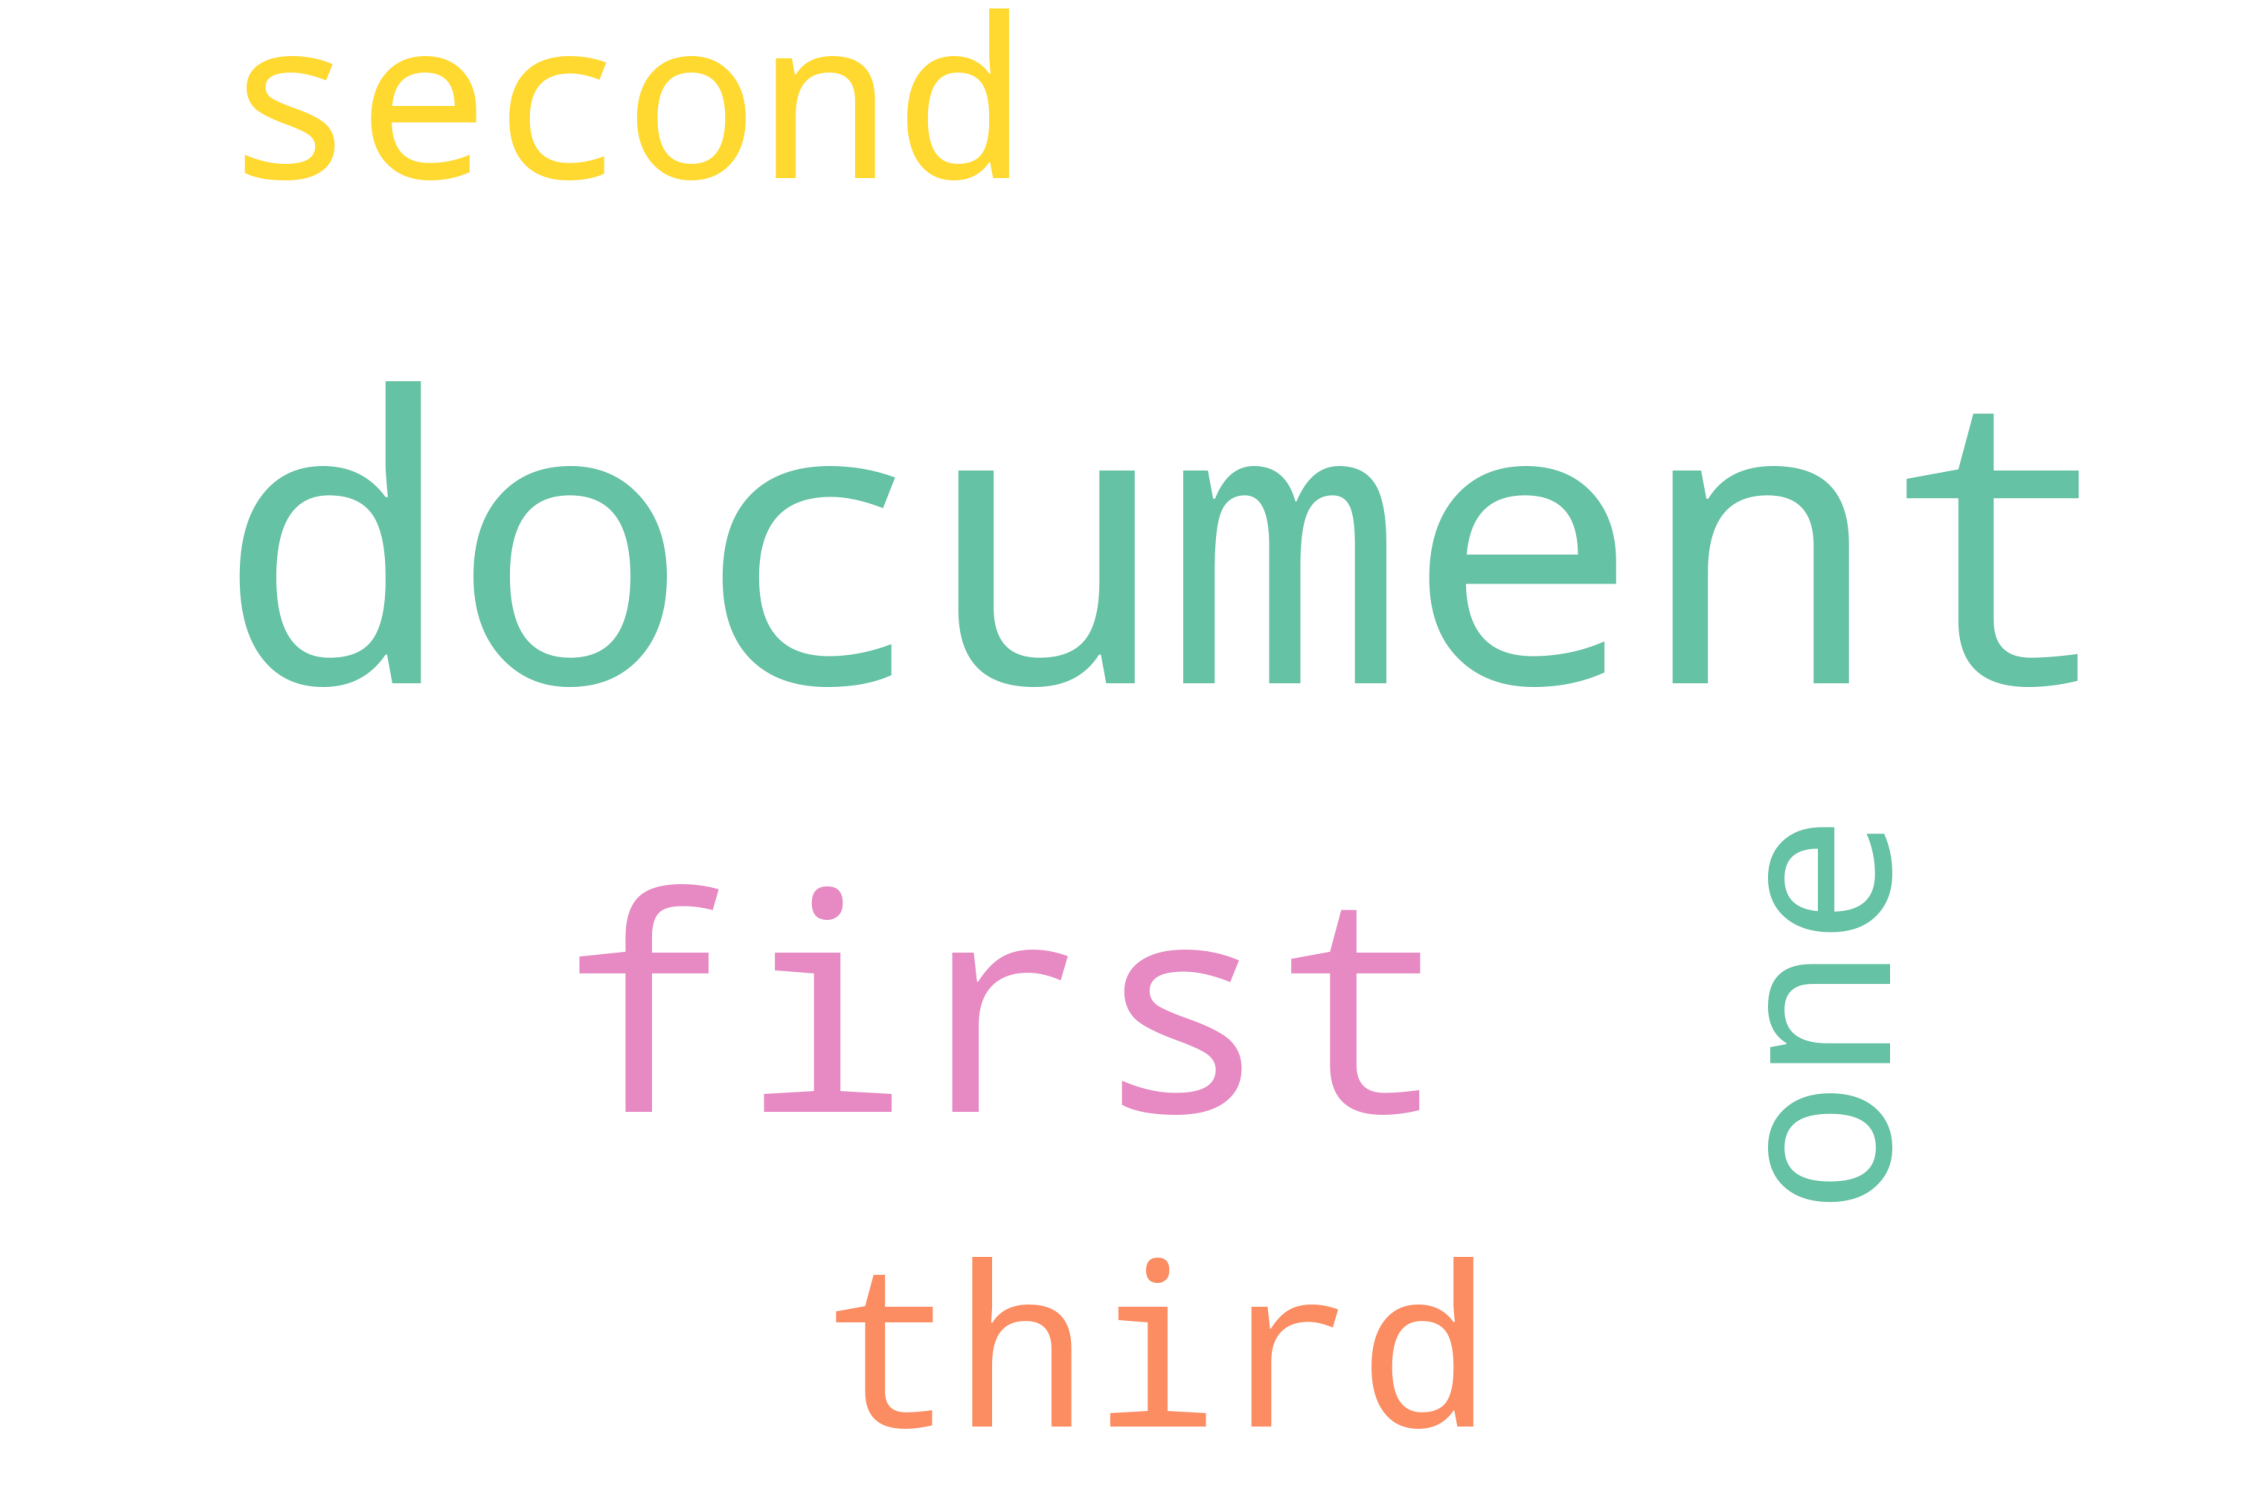

In [71]:
# Set figure size
plt.figure(figsize=(40, 30))
# Display image
plt.imshow(wordcloud) 
# No axis details
plt.axis("off")

In [80]:
x = Documents(data_frame=df2, text_column='ReviewText')
isinstance(x, Documents)

True

In [10]:
master = pd.read_csv(UTIL_PATH+"/lexicons/loughran/" + "LoughranMcDonald_MasterDictionary_2018.csv")

In [23]:
pos = master[master["Positive"]>0].Word.str.lower().tolist()


In [15]:
numbersList = [1, 2, 3]
str_list = ['one', 'two']
numbers_tuple = ('ONE', 'TWO', 'THREE', 'FOUR')

# Notice, the size of numbersList and numbers_tuple is different
result = zip(numbersList, numbers_tuple)

In [8]:
df_imdb_clean.groupby('sentiment').sum()['Count'].sort_values(ascending=False)

KeyError: 'Count'

In [28]:
df = pd.DataFrame({'A': [1, 1, 2, 1, 2],
                   'B': [np.nan, 2, 3, 4, 5],
                   'C': [1, 2, 1, 1, 2]}, columns=['A', 'B', 'C'])

In [36]:
animals=['giraffes', 'orangutans', 'monkeys']
y1=[0.1, 1.4, 2.3]
y2=[20, 14, 23]
y3=[30, 24, 43]

In [53]:
fig = make_subplots(rows=3, cols=1, specs = [[{}], [{"rowspan": 2}], [None]], shared_xaxes=True, vertical_spacing=0.00)
fig.add_trace(go.Scatter(x=animals, y=y1, mode='lines+markers', line_shape='spline'), row=1, col=1)
fig.add_trace(go.Bar(x=animals, y=y2, hoverinfo='all'), row=2,col=1)
fig.add_trace(go.Bar(x=animals, y=y3), row=2,col=1)
fig.update_layout(barmode='stack', plot_bgcolor='white', yaxis_visible=False, yaxis_showticklabels=False, yaxis2_visible=False, yaxis2_showticklabels=False)
fig.show()

In [23]:
corpus = [
...     'This is the first document.',
...     'This document is the second document.',
...     'And this is the third one.',
...     'Is this the first document?',
... ]

In [27]:
vec = CountVectorizer(ngram_range=(1, 1)).fit_transform(corpus)
vec.toarray()



array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

In [ ]:
pos_words_freq = [(word, sum_words[0, idx]) for word,
                idx in vec.vocabulary_.items() if word in lexi_dict['Positive']]
neg_words_freq = [(word, sum_words[0, idx]) for word,
                    idx in vec.vocabulary_.items() if word in lexi_dict['Positive']]

In [5]:
# Program to check the list contains elements of another list

# List1
List1 = ['python' ,  'javascript', 'csharp', 'go', 'c', 'c++']
 
# List2
List2 = ['swift' , 'php', 'python']
list3 = []

check =  any(item in List1 for item in list3)
 
if check is True:
    print("The list {} contains some elements of the list {}".format(List1, list3))    
else :
    print("No, List1 doesn't have any elements of the List2.")

No, List1 doesn't have any elements of the List2.


In [11]:
for k in range(0, len(List1)):
    print(List1[max(k-3,0):k])

[]
['python']
['python', 'javascript']
['python', 'javascript', 'csharp']
['javascript', 'csharp', 'go']
['csharp', 'go', 'c']


In [31]:
a = pd.Series([2, 1, 3, 3], name='A').unique()
for i in a:
    print(i)

2
1
3
